# Toxic Comment Classification Challenge: Starter Colab Notebook


Short Link: **tiny.cc/mlcc-toxic-starter-colab**

Kaggle challenge: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


## Problem & Objective

Build a model to Identify & categorize hate speech element from user comment




## Assumption

* The label/tagging was done via crowdsourcing which means that the dataset was rated by different people and the tagging might not be 100% accurate too

*   List item
*   List item



## import packages

In [0]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import SnowballStemmer


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


ModuleNotFoundError: ignored

## install additional packages ( NLTK, wordcloud)

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

In [0]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 7.0MB/s 


## Import  dataset & exploratory data analysis (EDA)

In [0]:
import pandas as pd
data = pd.read_csv("train.csv")


In [0]:
data.shape

In [0]:
data.head()

In [0]:
data.toxic.value_counts()

In [0]:
data[ data['toxic'] == 1]

In [0]:
## check for null number
data.isnull().sum()

In [0]:
## correlation matrix

corr=data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

high-correlated category (with coefficeint > 0.7 )

-- toxic - obscene

-- insult - obscene

-- insult - toxic


suprising toxic and severe_toxic was not high-correlated



## wordcloud

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
wc = WordCloud(background_color="black", 
                stopwords=STOPWORDS,width=2500, height=1800)

In [0]:
toxic=data[data.toxic==1]['comment_text'].values
severe_toxic=data[data.severe_toxic==1]['comment_text'].values
obscene=data[data.obscene==1]['comment_text'].values
threat=data[data.threat==1]['comment_text'].values
insult=data[data.insult==1]['comment_text'].values
identity_hate=data[data.identity_hate==1]['comment_text'].values

In [0]:
severe_toxic = data[data.severe_toxic==1]

(-0.5, 2499.5, 1799.5, -0.5)

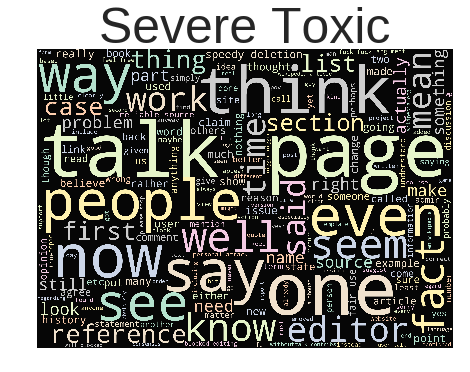

In [0]:
wc.generate(" ".join( data.comment_processed))
plt.title("Severe Toxic", fontsize=50)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

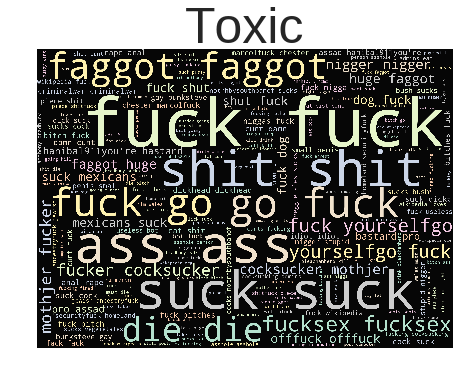

In [0]:
wc.generate(" ".join(severe_toxic.comment_processed))
plt.title("Toxic", fontsize=50)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

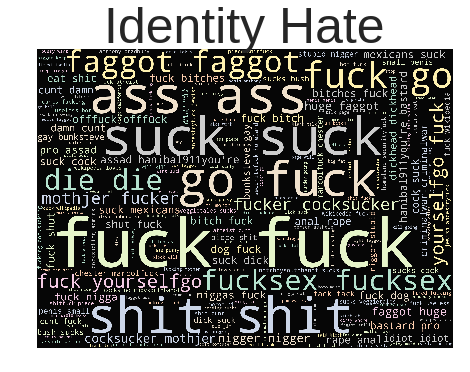

In [0]:
wc.generate(" ".join(severe_toxic.comment_processed))
plt.title("Identity Hate", fontsize=50)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

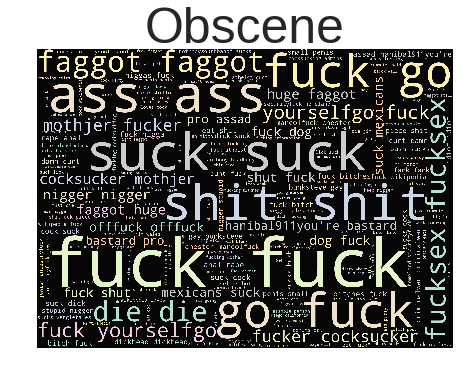

In [0]:
wc.generate(" ".join(severe_toxic.comment_processed))
plt.title("Obscene", fontsize=50)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 2499.5, 1799.5, -0.5)

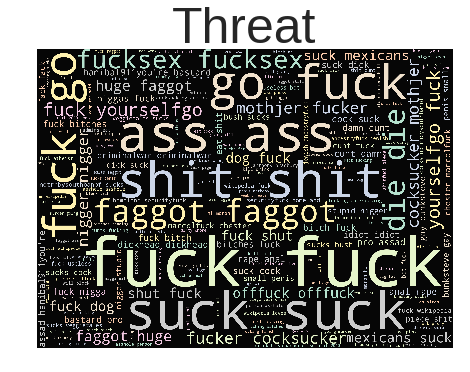

In [0]:
wc.generate(" ".join(severe_toxic.comment_processed))
plt.title("Threat", fontsize=50)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

## TF-IDF vectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer( strip_accents='unicode',analyzer='word',ngram_range=(1,1),
            use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')
"""tf = TfidfVectorizer(min_df=100,  max_features=100000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1)"""

"tf = TfidfVectorizer(min_df=100,  max_features=100000, \n            strip_accents='unicode', analyzer='word',ngram_range=(1,1),\n            use_idf=1,smooth_idf=1,sublinear_tf=1)"

In [0]:
def category_to_tfidf(category):
    tvec_weights = tf.fit_transform(category)
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': tf.get_feature_names(), 'weight': weights})
    return(weights_df.sort_values(by='weight', ascending=False).head(10))

In [0]:
toxic_idf=category_to_tfidf(toxic)
severe_toxic_idf=category_to_tfidf(severe_toxic)
threat_idf=category_to_tfidf(threat)
insult_idf=category_to_tfidf(insult)
obscene_idf=category_to_tfidf(obscene)
identity_hate_idf=category_to_tfidf(identity_hate)
toxic_idf.head(10)

,term,weight
12035,fuck,0.030439
12074,fucking,0.018095
17277,like,0.015347
31861,wikipedia,0.015215
9108,don,0.015162
16199,just,0.013976
26099,shit,0.013724
21099,page,0.013170
27682,stop,0.011530
27979,suck,0.011078


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


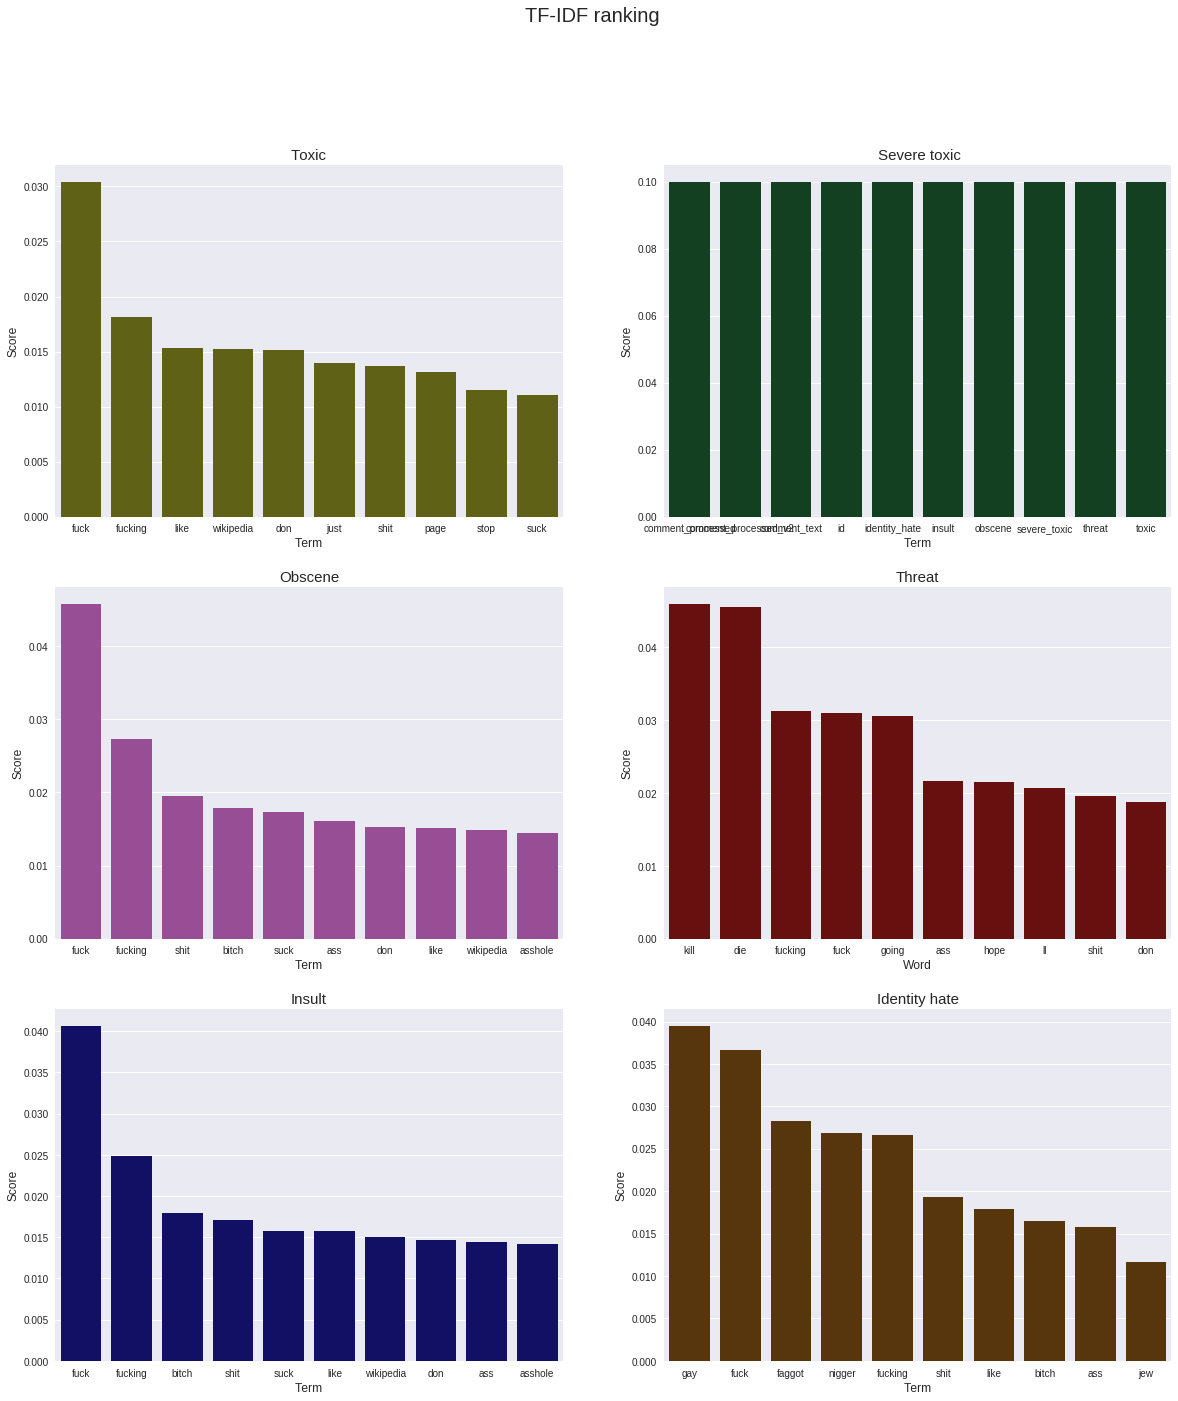

In [0]:
color_list = ["xkcd:brownish green", "xkcd:pine green", "xkcd:ugly purple",
               "xkcd:blood", "xkcd:deep blue", "xkcd:brown"]
plt.figure(figsize=(20,22))
plt.suptitle("TF-IDF ranking ",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplot2grid((3,2),(0,0))
sns.barplot(toxic_idf.term,
            toxic_idf.weight,color=color_list[0])
plt.title("Toxic",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(severe_toxic_idf.term,
            severe_toxic_idf.weight,color=color_list[1])
plt.title(" Severe toxic",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(1,0))
sns.barplot(obscene_idf.term,
            obscene_idf.weight,color=color_list[2])
plt.title("Obscene",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(1,1))
sns.barplot(threat_idf.term,
            threat_idf.weight,color=color_list[3])
plt.title("Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(insult_idf.term,
            insult_idf.weight,color=color_list[4])
plt.title("Insult",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(identity_hate_idf.term,
            identity_hate_idf.weight,color=color_list[5])
plt.title("Identity hate",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.show()

## Feature engineering  

### create new class 'Clean'

In [0]:
## create new category called clean

rowsums=data.iloc[:,2:].sum(axis=1)
data['clean']= (rowsums==0)
data['clean'] = data['clean'].astype(int)
data['clean'].sum()

143346

In [0]:
rowsums

In [0]:
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_processed,comment_processed_v2,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,explan edit made usernam hardcor metallica fan...,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,he matches this background colour i'm seemingl...,aww match background colour seem stuck thank t...,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it's...,hey man realli tri edit war guy constant remov...,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...,make real suggest improv wonder section statis...,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,sir hero chanc rememb page,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,congratulations from me as well use the tools ...,congratul well use tool well talk,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,cocksucker before you piss around on my work,cocksuck piss around work,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,your vandalism to the matt article has been re...,vandal matt shirvington articl revert pleas ban,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,sorry if the word was offensive to you anyway ...,sorri word nonsens offens anyway intend write ...,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,on this subject and which are contrary to thos...,align subject contrari dulithgow,1


In [0]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_processed,comment_processed_v2,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,explan edit made usernam hardcor metallica fan...,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,he matches this background colour i'm seemingl...,aww match background colour seem stuck thank t...,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it's...,hey man realli tri edit war guy constant remov...,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...,make real suggest improv wonder section statis...,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,sir hero chanc rememb page,True


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


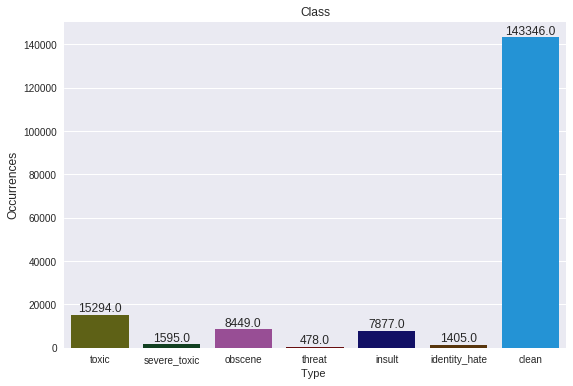

In [0]:
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=data.iloc[:,2:].sum()

plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

We have imbalance dataset where most of the comments are 'clean'. Our model need to consider this category when doing class prediction

In [0]:
# Just a list that contains all the text data. For me not to load the whole dataset everytime
comment_text_list = data.apply(lambda row : nltk.word_tokenize( row['comment_text']),axis=1)

In [0]:
comment_text_list

In [0]:
#Just storing each categories of non clean comments in specific arrays
toxic=train[train.toxic==1]['comment_text'].values
severe_toxic=train[train.severe_toxic==1]['comment_text'].values
obscene=train[train.obscene==1]['comment_text'].values
threat=train[train.threat==1]['comment_text'].values
insult=train[train.insult==1]['comment_text'].values
identity_hate=train[train.identity_hate==1]['comment_text'].values

## text pre-processing

In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train.comment_text)

Using TensorFlow backend.


In [0]:
## word cleaning for train dataset
word_to_id = tokenizer.word_index
id_to_word = {value:key for key,value in word_to_id.items()}

texts = data.comment_text.tolist()
sequences = tokenizer.texts_to_sequences(texts)
print(' '.join(id_to_word[id] for id in sequences[1] ))
cleanText = []
for seq in sequences:
    c = ' '.join(id_to_word[id] for id in seq)
    cleanText.append(c)
data['comment_processed'] = cleanText 

he matches this background colour i'm seemingly stuck with thanks talk 21 51 january 11 utc


In [0]:
## text cleaning 

snowball_stemmer = SnowballStemmer('english')


def clean( raw_text ):
    
    letters_only = re.sub("[^a-zA-Z]", " ", str(raw_text)) # Remove non-letters
    words = letters_only.lower().split()  # Convert to lower case, split into individual words                           
    stops = set(stopwords.words("english"))   # In Python, searching a set is much faster than searching a list, so convert the stop words to a set             
    meaningful_words = [w for w in words if not w in stops] 
    meaningful_words= [snowball_stemmer.stem(w) for w in meaningful_words ]# Remove stop words
    return( " ".join( meaningful_words ))  # Join the words back into one string separated by space, and return the result.

def process (text):
    clean_text=[]
    for i in range (0, len(text)):
        clean_text.append(clean(text[i]))    
    return (clean_text)


In [0]:
data['comment_processed_v2']  = process( data['comment_text'] )

In [0]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_processed,comment_processed_v2
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,explan edit made usernam hardcor metallica fan...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,he matches this background colour i'm seemingl...,aww match background colour seem stuck thank t...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it's...,hey man realli tri edit war guy constant remov...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...,make real suggest improv wonder section statis...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,sir hero chanc rememb page


## Train/Test Split

In [0]:
# Train / validation split
# dataset = data.sample(frac=1)
train = data.head(int(0.8 * len(dataset)))
test = data.tail(int(0.2 * len(dataset)))

In [0]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_processed
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,he matches this background colour i'm seemingl...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it's...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [0]:
train.shape

(127656, 9)

In [0]:
test.shape

(31914, 9)

In [0]:
train["comment_processed"].head()

0    explanation why the edits made under my userna...
1    he matches this background colour i'm seemingl...
2    hey man i'm really not trying to edit war it's...
3    more i can't make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: comment_processed, dtype: object

## LSTM v1

In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Embedding, Input
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [0]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [0]:
list_sentences_train = train["comment_processed"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_processed"].fillna("_na_").values

In [0]:
list_sentences_test

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:

## model 2
def get_model_v2():
    embed_size = 128
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
## model definition & setup

def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(7, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


model = get_model()
batch_size = 1024
epochs = 2

In [0]:
file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

y_test = model.predict(X_te)

In [0]:
file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

y_test = model.predict(X_te)

## LSTM v2.0

In [0]:
# Train / validation split
# dataset = data.sample(frac=1)
train = data.head(int(0.8 * len(dataset)))
test = data.tail(int(0.2 * len(dataset)))

In [0]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_processed,comment_processed_v2,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...,explan edit made usernam hardcor metallica fan...,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,he matches this background colour i'm seemingl...,aww match background colour seem stuck thank t...,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really not trying to edit war it's...,hey man realli tri edit war guy constant remov...,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can't make any real suggestions on impr...,make real suggest improv wonder section statis...,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...,sir hero chanc rememb page,1


In [0]:
list_sentences_train = train["comment_processed_v2"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate","clean"]
y = train[list_classes].values
list_sentences_test = test["comment_processed_v2"].fillna("_na_").values

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
file_path="weights_base_v3.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

y_test = model.predict(X_te)

Train on 114890 samples, validate on 12766 samples
Epoch 1/2
114890/114890 [==============================] - 509s 4ms/step - loss: 0.0579 - acc: 0.9788 - val_loss: 0.0595 - val_acc: 0.9778

Epoch 00001: val_loss improved from inf to 0.05946, saving model to weights_base_v3.hdf5
Epoch 2/2
114890/114890 [==============================] - 510s 4ms/step - loss: 0.0510 - acc: 0.9809 - val_loss: 0.0592 - val_acc: 0.9784

Epoch 00002: val_loss improved from 0.05946 to 0.05920, saving model to weights_base_v3.hdf5


In [0]:
y_test = model.predict(X_te[:2])

In [0]:
y_test

array([[6.9055363e-04, 1.3028544e-05, 1.4525272e-04, 4.5104087e-05,
        1.9253806e-04, 3.4153130e-05, 9.9931705e-01],
       [1.2747385e-03, 2.4434765e-05, 2.5987133e-04, 7.8947269e-05,
        3.1602450e-04, 6.8082991e-05, 9.9879372e-01]], dtype=float32)

In [0]:
X_te

array([[   0,    0,    0, ...,   21,    5,  453],
       [   0,    0,    0, ...,  551, 1344, 2447],
       [   0,    0,    0, ...,  612, 3018, 1035],
       ...,
       [   0,    0,    0, ..., 2129, 8328, 3176],
       [   0,    0,    0, ...,  257,   11,   36],
       [   0,    0,    0, ...,  286,   40, 1310]], dtype=int32)

In [0]:
train_dataset.head(10)

In [0]:
validation_dataset.head(10)

## Train a model

Your model's code start here. All the best :)



## References

* Example of Estimator for DNN-based text classification https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/learn/text_classification.py

* How to build a simple text classifier with TF-Hub https://www.tensorflow.org/tutorials/text_classification_with_tf_hub

* Tensorflow Estimator API: https://www.tensorflow.org/tutorials/recurrent

* Using pre-trained word embeddings in a Keras model https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

* Text Classification with TensorFlow Estimators http://ruder.io/text-classification-tensorflow-estimators/

* Scikit-Learns NLP documentation: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

* [Review on  Kaggle Toxic Comment Classification Challenge](https://medium.com/the-artificial-impostor/review-kaggle-toxic-comment-classification-challenge-part-1-934447339309)
